In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import networkx as nx


from netgraph import Graph, InteractiveGraph

from networkx.algorithms.community import girvan_newman, modularity_max, louvain_communities

from visu_utils import *

# white grid
sns.set_style("whitegrid")


%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:

PREFIX = "mteb_ds"
df_1 = pd.read_csv('exported_data/normalized_13.df')
df_2 = pd.read_csv('exported_data/normalized_multi_ds.df')

df = pd.concat([df_1, df_2])

df = text_embeddings_metadata_results_preprocessing(df, models=MODELS_MAIN_EXPES)
classifcation_df = pd.read_csv('exported_data/classification_many_2.csv')

classifcation_df['model'] = classifcation_df['model'].apply(lambda x: eval(x)[0])

METRIC = "I(X_1->X_2)/d_2"


In [40]:

df

,model_1,model_2,marg_modes,cond_modes,datasets,Unnamed: 0,id,date,d_1,d_2,...,ff_residual_connection,ff_activation,ff_layer_norm,ff_layers,ff_dim_hidden,I(X_1->X_2)/H(X_2),I(X_1->X_2)/d_1,I(X_1->X_2)/d_2,X,Y
0,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5,8,8,"('ag_news/train/embeddings.npy',)",0,fff7efd4-ad49-4181-b6af-f2f0e6f7ffff,2024-04-23 23:40:23,768,768,...,False,relu,True,2,0,1.043984,1.437165,1.437165,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5
1,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5,8,8,"('mteb/amazon_polarity/test/embeddings.npy', '...",0,90b83193-9c16-4057-a2ae-567d71679aa3,2024-04-07 14:42:10,768,768,...,False,relu,True,2,0,1.047920,1.408755,1.408755,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5
2,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5,8,8,"('mteb/amazon_polarity/test/embeddings.npy',)",0,af0a6d62-550e-48a3-88fe-7894fe196ad1,2024-04-23 23:40:54,768,768,...,False,relu,True,2,0,1.042361,1.410621,1.410621,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5
3,BAAI/bge-base-en-v1.5,GritLM/GritLM-7B,8,8,"('ag_news/train/embeddings.npy',)",0,ec6b172e-e549-4096-b8d6-53dc303af897,2024-04-24 01:14:48,768,4096,...,False,relu,True,2,0,0.466473,3.382202,0.634163,BAAI/bge-base-en-v1.5,GritLM/GritLM-7B
4,BAAI/bge-base-en-v1.5,GritLM/GritLM-7B,8,8,"('mteb/amazon_polarity/test/embeddings.npy', '...",0,2eb6973c-6309-4dfc-a9b0-0bb8e64b66a5,2024-04-07 17:47:53,768,4096,...,False,relu,True,2,0,0.422434,2.968637,0.556619,BAAI/bge-base-en-v1.5,GritLM/GritLM-7B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5803,thenlper/gte-large,thenlper/gte-base,8,8,"('mteb/amazon_polarity/test/embeddings.npy', '...",0,61269a48-0b5a-4a63-9904-b9aa64ce921e,2024-04-07 15:39:40,1024,768,...,False,relu,True,2,0,0.445457,0.457157,0.609543,thenlper/gte-large,thenlper/gte-base
5804,thenlper/gte-large,thenlper/gte-base,8,8,"('mteb/amazon_polarity/test/embeddings.npy',)",0,86244e55-1d00-4742-8202-d6ba7f7a0575,2024-04-24 00:01:45,1024,768,...,False,relu,True,2,0,0.376907,0.388508,0.518010,thenlper/gte-large,thenlper/gte-base
5805,thenlper/gte-large,thenlper/gte-large,8,8,"('ag_news/train/embeddings.npy',)",0,35476e9c-ebce-4808-a0cf-00f2ad51cc18,2024-04-23 23:48:57,1024,1024,...,False,relu,True,2,0,1.036494,1.419277,1.419277,thenlper/gte-large,thenlper/gte-large
5806,thenlper/gte-large,thenlper/gte-large,8,8,"('mteb/amazon_polarity/test/embeddings.npy', '...",0,c9f5895a-da48-4f24-8f10-43bef885e5f1,2024-04-07 16:06:16,1024,1024,...,False,relu,True,2,0,1.039146,1.423009,1.423009,thenlper/gte-large,thenlper/gte-large


In [42]:
correlation_table = []
for name, _df in df.groupby(['datasets']):
    
    print(name)
    
    rankings_per_task = make_rankings_table(classifcation_df, _df, METRIC, aggrefate_tasks=False)
    rankings_per_task = rankings_per_task[['model', 'dataset', 'value', 'ranking', 'rank', 'community']]


    rankings_per_task_classif = rankings_per_task[~rankings_per_task['dataset'].isna()]
    informativeness = rankings_per_task[rankings_per_task['ranking'] == 'informativeness']

    for dataset in rankings_per_task_classif['dataset'].unique():
        
        selected_ds_classif = rankings_per_task_classif[rankings_per_task_classif['dataset'] == dataset]

        temp = pd.concat([selected_ds_classif, informativeness])

        # pivot table, ranking
        temp_values = temp.pivot(columns='ranking', values='value', index=['model', 'community'])
        temp_ranking = temp.pivot(columns='ranking', values='rank', index=['model', 'community'])


        correlation_table.append({
            'Dataset' : name, 
            'Task': dataset,
            'Pearson': temp_values.corr().loc['classification', 'informativeness'],
            'Spearmann': temp_ranking.corr().loc['classification', 'informativeness'],
            'Kendall': temp_values.corr(method='kendall').loc['classification', 'informativeness'],
        })

correlation_table = pd.DataFrame(correlation_table)

('ag_news/train/embeddings.npy',)
('mteb/amazon_polarity/test/embeddings.npy', 'mteb/banking77/test/embeddings.npy', 'mteb/biosses-sts/test/embeddings.npy', 'mteb/sickr-sts/test/embeddings.npy', 'mteb/sts12-sts/test/embeddings.npy', 'mteb/sts13-sts/test/embeddings.npy', 'mteb/sts14-sts/test/embeddings.npy', 'mteb/sts15-sts/test/embeddings.npy', 'mteb/stsbenchmark-sts/test/embeddings.npy', 'mteb/stsbenchmark-sts/validation/embeddings.npy', 'snli/test/embeddings.npy', 'snli/validation/embeddings.npy')
('mteb/amazon_polarity/test/embeddings.npy',)


/tmp/ipykernel_186459/3714911314.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, _df in df.groupby(['datasets']):
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  )
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  )
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  )


<Axes: xlabel='Task', ylabel='Spearmann'>

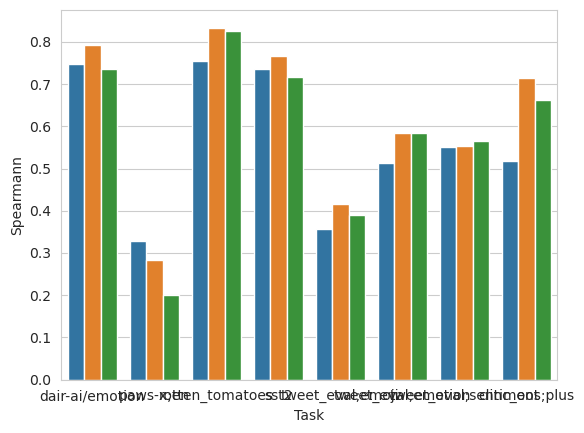

In [49]:
sns.barplot(data=correlation_table, hue="Dataset", legend=False, x="Task", y="Spearmann")

In [47]:
correlation_table

,Dataset,Task,Pearson,Spearmann,Kendall
0,"('ag_news/train/embeddings.npy',)",dair-ai/emotion,0.759399,0.747581,0.553088
1,"('ag_news/train/embeddings.npy',)",paws-x;en,0.335146,0.328573,0.210903
2,"('ag_news/train/embeddings.npy',)",rotten_tomatoes,0.829017,0.754261,0.510259
3,"('ag_news/train/embeddings.npy',)",sst2,0.812490,0.735601,0.519644
4,"('ag_news/train/embeddings.npy',)",tweet_eval;emoji,0.265714,0.357268,0.262032
5,"('ag_news/train/embeddings.npy',)",tweet_eval;emotion,0.711116,0.512111,0.349688
6,"('ag_news/train/embeddings.npy',)",tweet_eval;sentiment,0.777136,0.550835,0.398215
7,"('ag_news/train/embeddings.npy',)",clinc_oos;plus,0.613461,0.517178,0.333333
8,"('mteb/amazon_polarity/test/embeddings.npy', '...",dair-ai/emotion,0.745080,0.793711,0.587656
9,"('mteb/amazon_polarity/test/embeddings.npy', '...",paws-x;en,0.281536,0.283007,0.171582
